In [1]:
import numpy as np
np.random.seed(19)

In [2]:
%matplotlib inline

In [3]:
import pylab as pl
pl.rcParams['figure.dpi'] = 120

In [10]:
from mtgsdk import Card as QueryDB
import pickle
import csv

In [26]:
import random

class Card():
    
    def __init__(self, name):
        
        try:
            cc = QueryDB.where(name=name).array()[0]
            self.name = cc['name']
            self.types = cc['types']
            try:
                self.power = cc['power']
            except KeyError:
                self.power = None
            try:
                self.tough = cc['toughness']
            except KeyError:
                self.tough = None
            try:
                self.cost = cc['cmc']#.replace('{','').replace('}','')
            except KeyError:
                self.cost = None
            self._card = cc

        except IndexError:
            print("Couldn't find %s, skipping."%name)
            self.name = name
            self.types = []
            self.power = None
            self.tough = None
            self.cost = None
            self._card = None
        
    def is_type(self, type_string):
        return type_string.lower() in [t.lower() for t in self.types]
    
    def is_land(self):
        return self.is_type('land')
    
    def is_creature(self):
        return self.is_type('creature')
    
    def is_instant(self):
        return self.is_type('instant')
        
    def get_combined_cost(self):
        return np.sum(self.cost)
    
    def __repr__(self):
        return self.name

In [6]:
class Deck():
    
    def __init__(self, name):
        self.name = name
        self.library = []
        self.hand = []
        self.lands = 0
        
    def import_names(self, cards):
        for c in cards:
            self.library.append(Card(c))
        random.shuffle(self.library)

    def import_csv(self, filename='decks/white_green.csv'):
        cards = []
        with open(filename, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                if row[0] == 'Name':
                    continue
                howmany = int(row[-1])
                while howmany>0:
                    cards.append(row[0])
                    howmany -= 1
        self.import_names(cards)
        
    def draw(self, n=1):
        for i in range(n):
            picked = self.library[0]
            self.library = self.library[1:]
            self.hand = np.append(self.hand, picked)
#             print(picked.name)
        return picked
    
    def play(self):
        picked = self.draw()
        land = self.land()
        played = self.cast()
        discarded = self.discard()
#         print "Land", land, "Played", played, "Discarded", discarded
        return land, picked, played, discarded
        
    def land(self):
        yes_no = []
        for h in self.hand:
            yes_no.append(h.is_land())
        try:
            which = np.where(yes_no)[0][0]
            self.lands += 1
            self.hand = np.delete(self.hand, which)
            toret = 1
        except IndexError:
#             print "No land in hand. :("
            toret = 0
        return toret
    
    def cast(self):
        total_mana = self.lands
        played = []
        while total_mana > 0:
            try:
                costs = np.r_[[c.cost for c in self.hand]]
                which = np.random.choice([w for w in np.where(costs<=total_mana)[0] if self.hand[w]>0])
                total_mana -= self.hand[which]
                played.append(self.hand[which])
                self.hand = np.delete(self.hand, which) 
            except:
                break
        return played
    
    def discard(self):
        if len(self.hand) > 7:
            which = np.random.choice(np.where([not c.is_land() for c in self.hand])[0])
            toret = self.hand[which]
            self.hand = np.delete(self.hand, which)
        else:
            toret = None
        return toret
    
    def _reset(self, library):
        self.library = library
        random.shuffle(library)
        self.hand = []
        self.lands = 0
        
    def save(self, filename=None):
        if filename is None:
            filename = self.name
        with open(filename, 'wb') as f:
            pickle.dump(self.library, f)
            
    def load(self, filename):
        with open(filename, 'rb') as f:
            self._reset(pickle.load(f))

In [27]:
deck = Deck('white_green')

In [14]:
%%time
deck.import_csv('decks/white_green.csv')
deck.save('white_green.dck')

CPU times: user 1.24 s, sys: 56 ms, total: 1.3 s
Wall time: 20.7 s


In [28]:
%%time
deck.import_csv('decks/blue_black.csv')
deck.save('blue_black.dck')

Couldn't find Deja Vu, skipping.
CPU times: user 1.09 s, sys: 36.9 ms, total: 1.13 s
Wall time: 11.8 s


In [16]:
%%time
deck.import_csv('decks/green_nissa_duel_deck.csv')
deck.save('green.dck')

CPU times: user 1.11 s, sys: 67.3 ms, total: 1.18 s
Wall time: 12 s


In [11]:
deck.load('white_green')

In [38]:
deck.load('blue_black.dck')
which = np.where(['Deja' in c.name for c in deck.library])[0][0]
deck.library[which].cost = 3
deck.save('blue_black.dck')

In [42]:
deck.load('blue_black.dck')
deck.draw(7)
print(['%s'%c for c in deck.hand])
lands = [0]
hands = [len(deck.hand)]
for i in range(10):    
    print("----")
    l, draw, played, discarded = deck.play()
    print("Lands", deck.lands)
    print("Picked", draw, draw.cost)
    print("Played", [(p, p.cost if p is not None else None) for p in played])
    print("Discarded", discarded, discarded.cost if discarded is not None else None)
    print(['%s'%c for c in deck.hand])
    lands.append(deck.lands)
    hands.append(len(deck.hand))

['Talas Explorer', 'Frozen Shade', 'Swamp', 'Scavenging Scarab', 'Swamp', 'Swamp', 'Essence Drain']
----
Lands 1
Picked Swamp 0
Played []
Discarded None None
['Talas Explorer', 'Frozen Shade', 'Scavenging Scarab', 'Swamp', 'Swamp', 'Essence Drain', 'Swamp']
----
Lands 2
Picked Unholy Strength 1
Played []
Discarded None None
['Talas Explorer', 'Frozen Shade', 'Scavenging Scarab', 'Swamp', 'Essence Drain', 'Swamp', 'Unholy Strength']
----
Lands 3
Picked Dark Banishing 3
Played []
Discarded None None
['Talas Explorer', 'Frozen Shade', 'Scavenging Scarab', 'Essence Drain', 'Swamp', 'Unholy Strength', 'Dark Banishing']
----
Lands 4
Picked Dross Crocodile 4
Played []
Discarded None None
['Talas Explorer', 'Frozen Shade', 'Scavenging Scarab', 'Essence Drain', 'Unholy Strength', 'Dark Banishing', 'Dross Crocodile']
----
Lands 5
Picked Island 0
Played []
Discarded None None
['Talas Explorer', 'Frozen Shade', 'Scavenging Scarab', 'Essence Drain', 'Unholy Strength', 'Dark Banishing', 'Dross Croco

Now we simulate a number of such runs. First we encapsulate the above into the `simulate` function.

In [70]:
import pickle
with open('dump', 'wb') as f:
    pickle.dump(deck_library, f)

In [62]:
def simulate(deck, library, n=100, n_rounds=20):
    hh = []
    ll = []
    for i in range(n):

        deck._reset(library)

        lands = [0]
        hands = [len(deck.hand)]
        for i in range(n_rounds):    
            l, draw, played, discarded = deck.play()
            lands.append(deck.lands)
            hands.append(len(deck.hand))

        hh.append(hands)
        ll.append(lands)

    hh = np.r_[hh]
    ll = np.r_[ll]
    
    return hh, ll

Then we define 3 decks, red, black and green, and we simulate them.

In [63]:
# hh_r, ll_r = simulate(deck_r, n_rounds=30)
# hh_k, ll_k = simulate(deck_k, n_rounds=30)
hh_g, ll_g = simulate(deck, deck_library, n_rounds=30)

IndexError: list index out of range

Finally, we plot the average number of cards in hand in each round. Rapid decks tend to have a steeper curve. Slower decks tend to have a higher curve and only until later rounds the number of cards in hand start to decline.

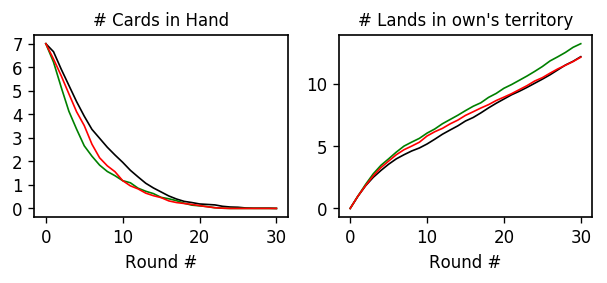

In [9]:
fig, axs = pl.subplots(1, 2, figsize=(6, 2))
axs[0].plot(hh_k.mean(0), color='k', lw=1)
axs[0].plot(hh_g.mean(0), color='g', lw=1)
axs[0].plot(hh_r.mean(0), color='r', lw=1)

axs[0].set_yticks(range(8))

axs[0].set_xlabel('Round #')
axs[0].set_title('# Cards in Hand')

axs[1].plot(ll_k.mean(0), color='k', lw=1)
axs[1].plot(ll_g.mean(0), color='g', lw=1)
axs[1].plot(ll_r.mean(0), color='r', lw=1)

# axs[1].set_yticks(range(8))

axs[1].set_xlabel('Round #')
axs[1].set_title('# Lands in own\'s territory')